In [13]:
import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    classification_report
)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor

import shap


In [14]:
runs_df = pd.read_csv("../data/cleaned/player_runs_dataset.csv")

print(runs_df.shape)
print(runs_df.columns)


(15842, 9)
Index(['batter', 'date', 'venue', 'bowling_team', 'recent_form',
       'venue_performance', 'opponent_performance', 'overall_average',
       'future_runs'],
      dtype='object')


In [15]:
RUNS_FEATURES = [
    "recent_form",
    "venue_performance",
    "opponent_performance",
    "overall_average"
]

RUNS_TARGET = "future_runs"

X_runs = runs_df[RUNS_FEATURES]
y_runs = runs_df[RUNS_TARGET]


In [16]:
split = int(len(runs_df) * 0.8)

Xr_train, Xr_test = X_runs.iloc[:split], X_runs.iloc[split:]
yr_train, yr_test = y_runs.iloc[:split], y_runs.iloc[split:]


In [17]:
baseline_pred = Xr_test["recent_form"]

print("Baseline RMSE:",
      np.sqrt(mean_squared_error(yr_test, baseline_pred)))
print("Baseline MAE:",
      mean_absolute_error(yr_test, baseline_pred))
print("Baseline R2:",
      r2_score(yr_test, baseline_pred))


Baseline RMSE: 22.626564780204497
Baseline MAE: 17.03704544964034
Baseline R2: 0.008995371074025815


In [18]:
rf_runs = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

rf_runs.fit(Xr_train, yr_train)
rf_pred = rf_runs.predict(Xr_test)

print("RF RMSE:", np.sqrt(mean_squared_error(yr_test, rf_pred)))
print("RF R2 :", r2_score(yr_test, rf_pred))


RF RMSE: 20.858681656718627
RF R2 : 0.1578059896698596


In [19]:
xgb_runs = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_runs.fit(Xr_train, yr_train)
xgb_pred = xgb_runs.predict(Xr_test)

print("XGB RMSE:", np.sqrt(mean_squared_error(yr_test, xgb_pred)))
print("XGB R2 :", r2_score(yr_test, xgb_pred))


XGB RMSE: 21.20793483855986
XGB R2 : 0.1293668541976456


ExactExplainer explainer: 3170it [00:21, 114.69it/s]                                                                   


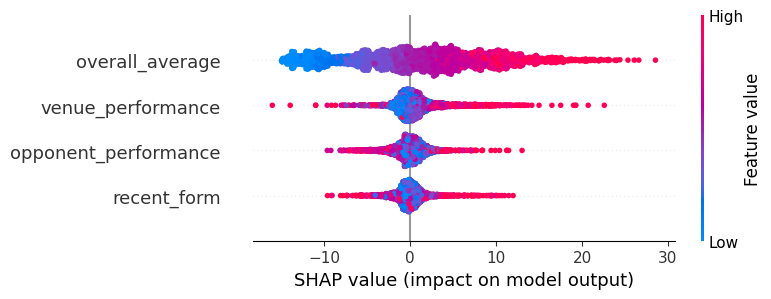

In [21]:
import shap

# Use model-agnostic explainer (SAFE)
explainer_runs = shap.Explainer(
    xgb_runs.predict,   # pass predict function
    Xr_train            # background data
)

shap_values_runs = explainer_runs(Xr_test)

shap.summary_plot(shap_values_runs, Xr_test)




In [23]:
joblib.dump(xgb_runs, "../models/xgb_runs_model.pkl")
print("Runs model saved ✅")


Runs model saved ✅


In [24]:
wicket_df = pd.read_csv("../data/cleaned/player_wicket_dataset.csv")

print(wicket_df.shape)
print(wicket_df.columns)


(13410, 10)
Index(['batter', 'date', 'venue', 'bowling_team', 'recent_wicket_rate',
       'venue_wicket_rate', 'opponent_wicket_rate', 'career_wicket_rate',
       'strike_rate', 'future_wicket'],
      dtype='object')


In [25]:
WICKET_FEATURES = [
    "recent_wicket_rate",
    "venue_wicket_rate",
    "opponent_wicket_rate",
    "career_wicket_rate",
    "strike_rate"
]

WICKET_TARGET = "future_wicket"

X_wicket = wicket_df[WICKET_FEATURES]
y_wicket = wicket_df[WICKET_TARGET]


In [26]:
split = int(len(wicket_df) * 0.8)

Xw_train, Xw_test = X_wicket.iloc[:split], X_wicket.iloc[split:]
yw_train, yw_test = y_wicket.iloc[:split], y_wicket.iloc[split:]


In [27]:
wicket_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])


In [32]:
# Imports
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# 1️⃣ Handle class imbalance safely
ros = RandomOverSampler(random_state=42)
Xw_train_res, yw_train_res = ros.fit_resample(Xw_train, yw_train)

# 2️⃣ Create pipeline with class-weighted RandomForest
wicket_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 2️⃣ Fit your pipeline on balanced data
wicket_pipeline.fit(Xw_train_res, yw_train_res)

# 3️⃣ Make predictions
wicket_pred = wicket_pipeline.predict(Xw_test)

# 4️⃣ Check which classes were predicted
print("Predicted class distribution:", np.unique(wicket_pred, return_counts=True))

# 5️⃣ Print metrics safely without warnings
print("Accuracy:", accuracy_score(yw_test, wicket_pred))
print(classification_report(yw_test, wicket_pred, zero_division=0))


Predicted class distribution: (array([0, 1, 2]), array([ 641, 1977,   64]))
Accuracy: 0.6461595824011931
              precision    recall  f1-score   support

           0       0.36      0.33      0.35       695
           1       0.76      0.77      0.77      1948
           2       0.00      0.00      0.00        39

    accuracy                           0.65      2682
   macro avg       0.37      0.37      0.37      2682
weighted avg       0.65      0.65      0.65      2682



In [33]:
joblib.dump(wicket_pipeline, "../models/xgb_wicket_model.pkl")
print("Wicket model saved ✅")


Wicket model saved ✅
